In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['yellow', 'black', 'red', 'rufous', 'orange', 'white', 'brown','grey', 'olive', 'buff', 'blue'
                          , 'green', 'purple', 'pink'])
folder = "./Birds/"

### Load Data and preprocess

In [4]:
X_train_vgg16 = np.load(folder+"Birds_VGG_avg_train.npy")
#X_train_vgg16 = np.load(folder+"Birds_VGG_train.npy")

Z_train = np.loadtxt(folder+"Birds_Z_train.txt",dtype='int')
train_dat = Z_train != -1
Z_train = Z_train[train_dat]
X_train_vgg16 = X_train_vgg16[train_dat]

X_test_vgg16 = np.load(folder+"Birds_VGG_avg_test.npy")
#X_test_vgg16 = np.load(folder+"Birds_VGG_test.npy")

Z_test = np.loadtxt(folder+"Birds_Z_test.txt",dtype='int')
test_dat = Z_test != -1
Z_test = Z_test[test_dat]
X_test_vgg16 = X_test_vgg16[test_dat]

print("Input train shape:",X_train_vgg16.shape)
print("Label train shape:",Z_train.shape)

print("Input test shape:",X_test_vgg16.shape)
print("Label test shape:",Z_test.shape)

Input train shape: (2986, 512)
Label train shape: (2986,)
Input test shape: (3020, 512)
Label test shape: (3020,)


In [5]:
Xstd_train = X_train_vgg16
Xstd_test = X_test_vgg16

In [5]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

ValueError: Found array with dim 4. StandardScaler expected <= 2.

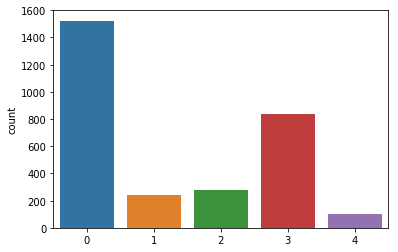

In [6]:
sns.countplot(Z_train)
plt.show()

### Load annotations / Generate

In [7]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16')[train_dat] #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 2 annotators that do not annotate on this set 
Shape (data,annotators):  (2986, 482)
Classes:  5


In [ ]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

In [30]:
np.savetxt(folder+"answers_v2.txt",new_annotations, delimiter=",", fmt="%i")

In [8]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.7       , 0.2       , 0.1       , 0.        ],
        [0.53333336, 0.46666667, 0.        , 0.        ],
        [0.5       , 0.        , 0.5       , 0.        ],
        [0.        , 0.        , 1.        , 0.        ]],

       [[0.5802469 , 0.18518518, 0.2345679 , 0.        ],
        [0.10416666, 0.875     , 0.02083333, 0.        ],
        [0.02857143, 0.14285715, 0.5714286 , 0.25714287],
        [0.        , 0.33333334, 0.        , 0.6666667 ]],

       [[0.8372093 , 0.        , 0.1627907 , 0.        ],
        [0.36842105, 0.36842105, 0.15789473, 0.10526316],
        [0.07142857, 0.        , 0.9285714 , 0.        ],
        [0.        , 0.        , 0.        , 1.        ]],

       ...,

       [[0.5       , 0.        , 0.        , 0.5       ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.25      , 0.25      , 0.25      , 0.25      ],
        [0.25      , 0.25      , 0.25      , 0.25      ]],

       [[0.33333334, 0.6666667 , 0.        , 0.    

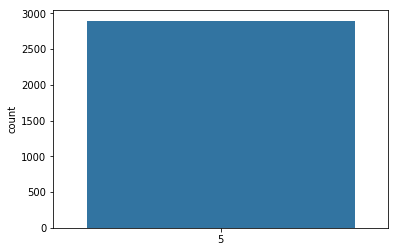

Minimum annotations in a example:  5
Maximum annotations in a example:  5
T data (expected value):  5.0
Graphics of T weights


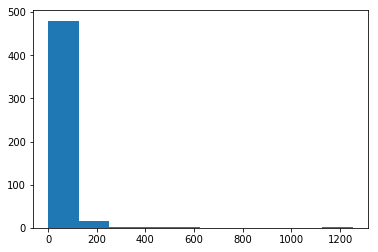

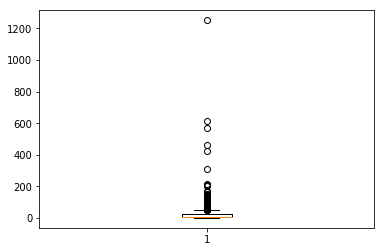

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  1252
Mean annotations by an annotator:  28.902195608782435


In [9]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [8]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [17]:
## class weights??
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(Z_train), Z_train)
weights

array([0.39212081, 2.44754098, 2.13285714, 0.71264916, 5.91287129])

In [18]:
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)
Z_test_onehot = keras.utils.to_categorical(Z_test, num_classes=Kl)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=True,drop=0.25) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.summary()
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback]
                  ,validation_data=(Xstd_test,Z_test_onehot), class_weight=weights)
clone_UB = Clonable_Model(model_UB)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

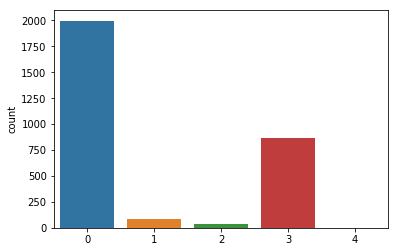

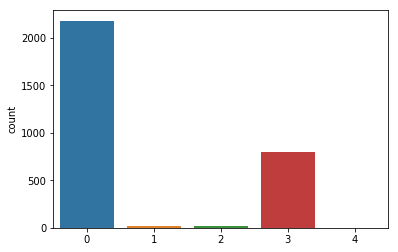

In [19]:
sns.countplot(Z_train_pred)
plt.show()
sns.countplot(Z_test_pred)
plt.show()

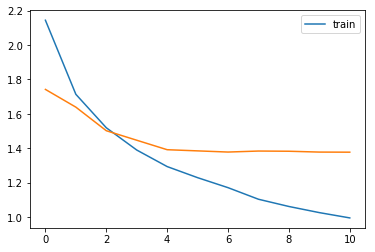

In [20]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [21]:
N = Xstd_train.shape[0]
evaluate = Evaluation_metrics(model_UB,'keras',N)
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7184,0.7184,0.4503


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.451,0.451,0.1813


### Infer Labels (without predictive model)

In [23]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.119901 sec
Representation for DS in 0.070634 sec
Estimation MV in 0.000460 sec


/home/fmena/Desktop/Dataset_Tesis/MixtureofGroups/code/utils.py:27: RuntimeWarning: invalid value encountered in true_divide
  return aux/aux.sum(axis=-1,keepdims=True) #normalize


Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -7534.017438927471
2 	 -6956.08133493833 	0.1880	0.725356	0.076710
3 	 -6788.145933468884 	0.3587	0.057003	0.024142
4 	 -6707.677433424667 	0.3046	0.064895	0.011854
5 	 -6655.490867137155 	0.2319	611.491150	0.007780
6 	 -6620.791949652603 	0.1415	1962.622559	0.005214
7 	 -6598.054450614903 	0.0726	4122.939941	0.003434
8 	 -6582.435076056545 	0.0398	6406.563477	0.002367
9 	 -6571.503695132394 	0.0256	5020.444824	0.001661
10 	 -6563.379116780399 	0.0189	7023.509766	0.001236
11 	 -6557.576767046472 	0.0162	4824.222168	0.000884
12 	 -6552.5437731846305 	0.0126	4082.619629	0.000768
13 	 -6547.823026455659 	0.0108	3509.409180	0.000720
14 	 -6543.968480598593 	0.0105	3097.444092	0.000589
15 	 -6539.933397380433 	0.0086	2882.283691	0.000617
16 	 -6537.403994193937 	0.0076	2042.118774	0.000387
17 	 -6534.629318075942 	0.0066	1853.409424	0.000424
18 	 -6532.788417226299 	0.0075	1024.407104	0.000282
19 	 -6531.067272039177 	0.0064	728.415955	0.00

In [28]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("F1 MV  on train:",f1_score(Z_train,mv_onehot.argmax(axis=1),average="macro"))

print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))
print("F1 D&S  on train:",f1_score(Z_train,ds_labels.argmax(axis=1),average="macro"))

ACC MV on train: 0.954
F1 MV  on train: 0.6896623713452912
ACC D&S on train: 0.8146666666666667
F1 D&S  on train: 0.33045450264294407


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [29]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 12


In [13]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

NameError: name 'clone_UB' is not defined

In [14]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

NameError: name 'clone_UB' is not defined

### Raykar Model (joint predict model)

In [15]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (3000, 459, 14)


In [16]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

NameError: name 'Xstd_train' is not defined

In [27]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test)

### Our Proposed

In [95]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [98]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 4 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 ...
 [0 5 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
shape: (3000, 14)


In [ ]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [ ]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [20]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

459


NameError: name 'logL_Mchange' is not defined

1, 2 o 3...

In [21]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [22]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

NameError: name 'Xstd_train' is not defined

In [23]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

NameError: name 'gMixture_Global' is not defined

In [24]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

NameError: name 'logL_hists' is not defined

<Figure size 1080x504 with 0 Axes>

In [96]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (459, 459)


shape of annotator representation (T, R_t)= (459, 196)


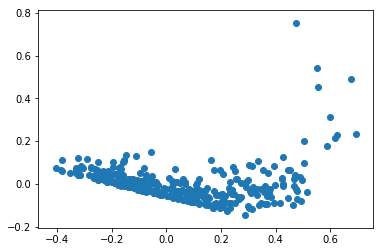

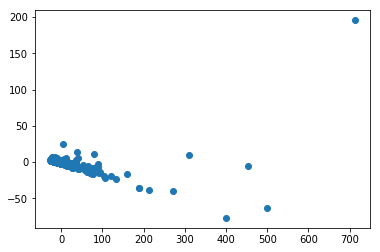

array([[ 0.,  9.,  1., ...,  0.,  0.,  0.],
       [ 0., 15.,  0., ...,  0.,  0.,  0.],
       [ 0., 63.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  8.,  0., ...,  0.,  0.,  0.],
       [ 0.,  3.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.]])

In [99]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
#A_rep = np.zeros((conf_mat.shape[0], Kl))
#for t in range(A_rep.shape[0]):
#    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [27]:
#different M_seted??
M_seted = 3

In [28]:
gMixture_Ind1 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("mlp",128,1,BatchN=False,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron",T, M_seted, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i = gMixture_Ind1.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

NameError: name 'Xstd_train' is not defined

In [29]:
Z_train_p = gMixture_Ind1.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

NameError: name 'gMixture_Ind1' is not defined

In [30]:
gMixture_Ind2 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("mlp",128,1,BatchN=False,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i = gMixture_Ind2.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

NameError: name 'Xstd_train' is not defined

In [31]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL) 

NameError: name 'Xstd_train' is not defined

In [32]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

NameError: name 'gMixture_Ind3' is not defined

### Compare trained models

In [14]:
#Import it:
from code.evaluation import Evaluation_metrics

colors = {0: 'b', 1:'r' ,2:'g'}
marker_s = {0: 'X', 1:'o', 2:'P'}

def plot_alphas(alphas_training):
    values = np.asarray(alphas_training)
    if len(values.shape) == 3:
        group_f = values[-1].argmax(axis=-1) #coloreado por el grupo del final..
        
        for m in range(M_seted):
            plt.figure(figsize=(15,7))
            for t in range(values.shape[1]):
                plt.plot(values[:,t,m], color=colors[group_f[t]], markersize=5)
            plt.title("Group "+str(m))
            plt.show()

        plt.figure(figsize=(15,10))
        for t in range(values.shape[1]):
            grupos_t_train = values[:,t,:].argmax(axis=-1)+t/values.shape[1]
            plt.plot(grupos_t_train, markersize=5, color=colors[group_f[t]])
            #plt.plot(grupos_t_train, markersize=5, marker=marker_s[group_f[t]])

        for m in range(M_seted+1):
            plt.hlines(m, 0,values.shape[0], linestyles="dashed")
        plt.show()
        
    else:
        plt.figure(figsize=(15,7))
        for m in range(M_seted):
            plt.plot(values[:,m], color=colors[m], markersize=5, label="Group "+str(m))
        plt.legend()
        plt.show()

In [27]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.9993,0.9993,0.9715


Test
A result


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.9153,0.9153,0.0956


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


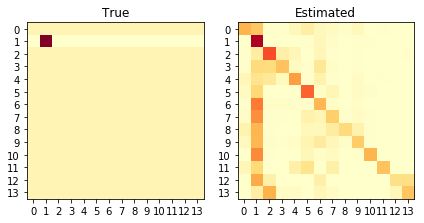

JS divergence: 0.3843	Norm Frobenius: 0.1238


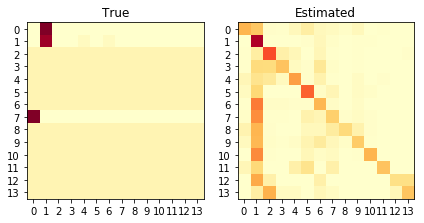

JS divergence: 0.4314	Norm Frobenius: 0.1514


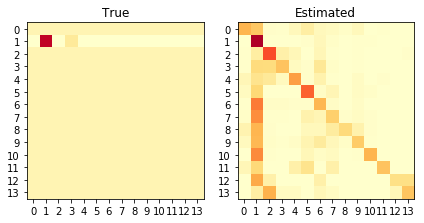

JS divergence: 0.3886	Norm Frobenius: 0.1240


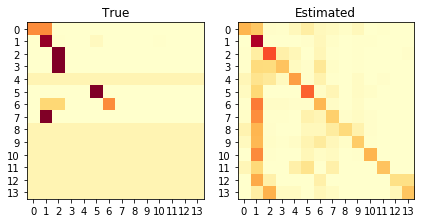

JS divergence: 0.3249	Norm Frobenius: 0.1262


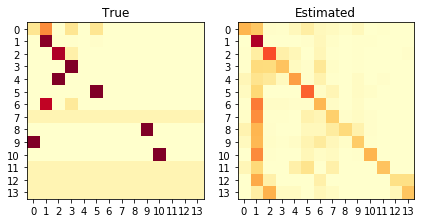

JS divergence: 0.4171	Norm Frobenius: 0.1735


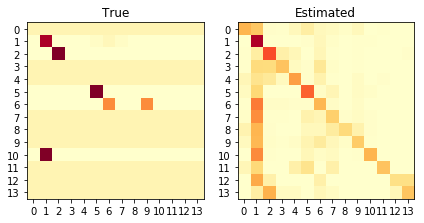

JS divergence: 0.3369	Norm Frobenius: 0.1228


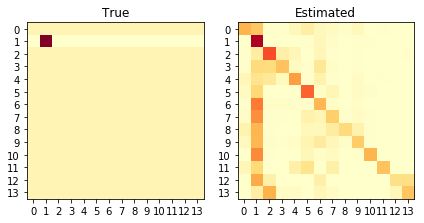

JS divergence: 0.3843	Norm Frobenius: 0.1238


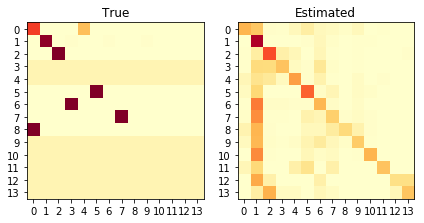

JS divergence: 0.4267	Norm Frobenius: 0.1640


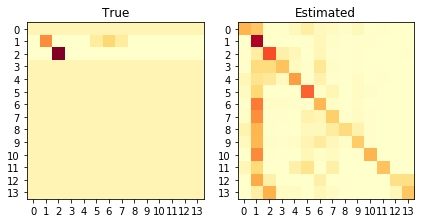

JS divergence: 0.3771	Norm Frobenius: 0.1242


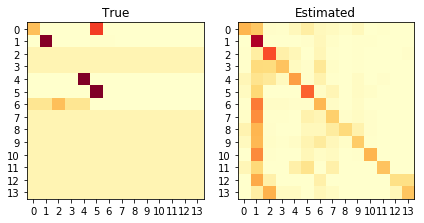

JS divergence: 0.3798	Norm Frobenius: 0.1320


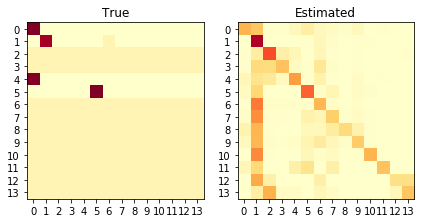

JS divergence: 0.4080	Norm Frobenius: 0.1461


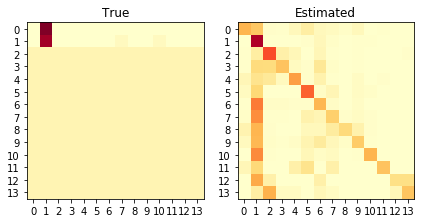

JS divergence: 0.3946	Norm Frobenius: 0.1327


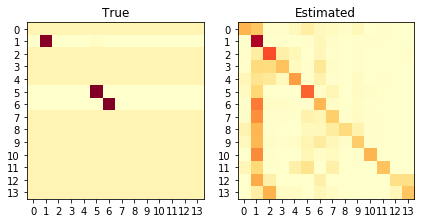

JS divergence: 0.3644	Norm Frobenius: 0.1290


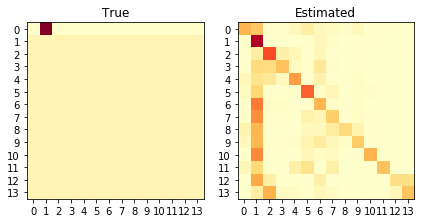

JS divergence: 0.4363	Norm Frobenius: 0.1462


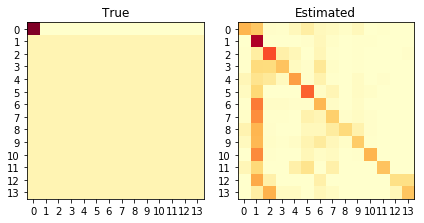

JS divergence: 0.4321	Norm Frobenius: 0.1441
Calculate confusion matrix on global version


ValueError: operands could not be broadcast together with shapes (14,14) (12,14) 

In [30]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [36]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

NameError: name 'Evaluation_metrics' is not defined

In [37]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

NameError: name 'Evaluation_metrics' is not defined

In [38]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

NameError: name 'Evaluation_metrics' is not defined

In [39]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [40]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [41]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual1 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [42]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual3 multiples runs***") #lambda = 1

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

NameError: name 'Evaluation_metrics' is not defined

In [43]:
plot_alphas(gMixture_Ind1.alphas_training)

NameError: name 'plot_alphas' is not defined

In [44]:
plot_alphas(gMixture_Ind3.alphas_training)

NameError: name 'plot_alphas' is not defined

### project confusion matrices

In [45]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

NameError: name 'gMixture_Global' is not defined

NameError: name 'centroids_plot_G' is not defined

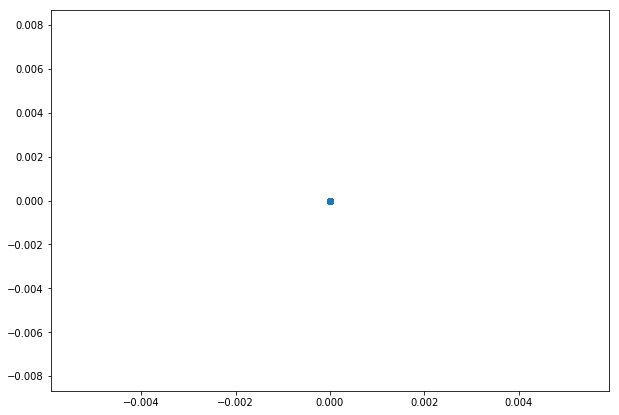

In [46]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo